In [1]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_bak_2015.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4081 entries, 0 to 4080
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   studium_id              4081 non-null   int64  
 1   pohlavi_kod             4081 non-null   int64  
 2   je_cech                 4081 non-null   int64  
 3   datum_zahajeni          4081 non-null   int64  
 4   rok_maturity            4081 non-null   int64  
 5   maturita_nastup_rozdil  4081 non-null   int64  
 6   gymnazium               4081 non-null   int64  
 7   praha                   4081 non-null   int64  
 8   scio                    4081 non-null   int64  
 9   olym                    4081 non-null   int64  
 10  zkouska                 4081 non-null   int64  
 11  prominuti               4081 non-null   int64  
 12  dostudoval_uspesne      4081 non-null   int64  
 13  BI-PA1                  3997 non-null   float64
 14  BI-PAI                  3894 non-null   

In [4]:
matrix_bak.mean()

studium_id                1.467385e+07
pohlavi_kod               1.261946e-01
je_cech                   7.743200e-01
datum_zahajeni            2.017257e+03
rok_maturity              2.016399e+03
maturita_nastup_rozdil    8.576329e-01
gymnazium                 5.442294e-01
praha                     5.390836e-02
scio                      9.605489e-02
olym                      1.021808e-01
zkouska                   3.479539e-02
prominuti                 2.719922e-02
dostudoval_uspesne        2.038716e-01
BI-PA1                    3.219665e+00
BI-PAI                    2.756292e+00
BI-CAO                    2.042218e+00
BI-PS1                    3.093703e+00
BI-MLO                    2.999872e+00
BI-ZMA                    3.213366e+00
BI-PA2                    2.970405e+00
BI-DBS                    2.553840e+00
BI-SAP                    2.460257e+00
BI-LIN                    3.254583e+00
BI-AG1                    2.851031e+00
BI-AAG                    2.810033e+00
BI-ZDM                   

## Příprava datasetu

### Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Přidání příznaků

In [6]:
matrix_bak['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-EMP'].mean(axis=1)

In [7]:
matrix_bak.mean()

pohlavi_kod                  0.126195
je_cech                      0.774320
datum_zahajeni            2017.256555
rok_maturity              2016.398922
maturita_nastup_rozdil       0.857633
gymnazium                    0.544229
praha                        0.053908
scio                         0.096055
olym                         0.102181
zkouska                      0.034795
prominuti                    0.027199
dostudoval_uspesne           0.203872
BI-PA1                       3.219665
BI-PAI                       2.756292
BI-CAO                       2.042218
BI-PS1                       3.093703
BI-MLO                       2.999872
BI-ZMA                       3.213366
BI-PA2                       2.970405
BI-DBS                       2.553840
BI-SAP                       2.460257
BI-LIN                       3.254583
BI-AG1                       2.851031
BI-AAG                       2.810033
BI-ZDM                       2.908228
BI-OSY                       2.718677
BI-PSI      

### Doplnění NaN hodnot

##### Doplnění pomocí KNNImputer

In [8]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
matrix_bak = pd.DataFrame(imputer.fit_transform(matrix_bak), index=matrix_bak.index, columns=matrix_bak.columns)

In [9]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4081 entries, 19374606 to 11740806
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pohlavi_kod             4081 non-null   float64
 1   je_cech                 4081 non-null   float64
 2   datum_zahajeni          4081 non-null   float64
 3   rok_maturity            4081 non-null   float64
 4   maturita_nastup_rozdil  4081 non-null   float64
 5   gymnazium               4081 non-null   float64
 6   praha                   4081 non-null   float64
 7   scio                    4081 non-null   float64
 8   olym                    4081 non-null   float64
 9   zkouska                 4081 non-null   float64
 10  prominuti               4081 non-null   float64
 11  dostudoval_uspesne      4081 non-null   float64
 12  BI-PA1                  4081 non-null   float64
 13  BI-PAI                  4081 non-null   float64
 14  BI-CAO                  4081 

#### Zaokrouhlení doplněných hodnot

In [10]:
grades = [1, 1.5, 2, 2.5, 3, 4]

In [11]:
def custom_round(value):
    return min(grades, key=lambda x:abs(x-value))

In [12]:
matrix_bak.loc[:, 'BI-PA1':'BI-EMP'] = matrix_bak.loc[:, 'BI-PA1':'BI-EMP'].applymap(custom_round)

In [13]:
matrix_bak

pohlavi_kod  je_cech  datum_zahajeni  rok_maturity  \
studium_id                                                       
19374606            0.0      1.0          2021.0        2009.0   
12375406            0.0      1.0          2015.0        2009.0   
11736906            0.0      1.0          2015.0        2009.0   
12032306            0.0      1.0          2015.0        2007.0   
15613006            0.0      1.0          2018.0        2009.0   
12948006            1.0      1.0          2016.0        2010.0   
11703806            0.0      1.0          2015.0        2010.0   
12967806            0.0      1.0          2016.0        2010.0   
11738606            0.0      0.0          2015.0        2010.0   
11719706            0.0      1.0          2015.0        2010.0   
11675306            0.0      0.0          2015.0        2010.0   
12987806            0.0      1.0          2016.0        2010.0   
11743906            0.0      1.0          2015.0        2010.0   
13016006            0.0      1.0          2016.0        2010.0   
12036006            0.0      1.0          2015.0        2010.0   
13512306            0.0      1.0          2016.0        2011.0   
12987706            0.0      1.0          2016.0        2010.0   
11678106            0.0      1.0          2015.0        2010.0   
13518506            0.0      1.0          2016.0        2011.0   
14256606            0.0      0.0          2017.0        2011.0   
11727206            0.0      1.0          2015.0        2011.0   
11736306            0.0      1.0          2015.0        2011.0   
12967906            0.0      1.0          2016.0        2011.0   
11703506            0.0      1.0          2015.0        2011.0   
13010106            0.0      1.0          2016.0        2011.0   
14800306            0.0      1.0          2017.0        2011.0   
11744706            1.0      1.0          2015.0        2011.0   
11696406            1.0      0.0          2015.0        2010.0   
12973406            0.0      1.0          2016.0        2011.0   
11737806            0.0      1.0          2015.0        2011.0   
12035506            1.0      0.0          2015.0        2011.0   
13512006            0.0      1.0          2016.0        2011.0   
12964406            0.0      1.0          2016.0        2011.0   
12994106            1.0      1.0          2016.0        2011.0   
11742506            0.0      1.0          2015.0        2011.0   
11712706            0.0      1.0          2015.0        2011.0   
13518806            0.0      1.0          2016.0        2011.0   
11735606            0.0      1.0          2015.0        2011.0   
13518606            0.0      1.0          2016.0        2011.0   
15586306            0.0      1.0          2018.0        2011.0   
13519806            0.0      1.0          2016.0        2011.0   
11686106            0.0      1.0          2015.0        2012.0   
11692606            0.0      1.0          2015.0        2012.0   
13013306            0.0      1.0          2016.0        2012.0   
11713906            0.0      1.0          2015.0        2012.0   
12978506            0.0      1.0          2016.0        2012.0   
14283706            0.0      1.0          2017.0        2012.0   
11736706            0.0      1.0          2015.0        2012.0   
11676006            0.0      1.0          2015.0        2012.0   
12033706            0.0      1.0          2015.0        2012.0   
12964506            0.0      1.0          2016.0        2012.0   
16724706            0.0      1.0          2019.0        2012.0   
12954706            0.0      1.0          2016.0        2012.0   
12034706            0.0      0.0          2015.0        2012.0   
12959206            0.0      1.0          2016.0        2012.0   
14803806            0.0      1.0          2017.0        2012.0   
11733706            0.0      1.0          2015.0        2012.0   
11707706            0.0      1.0          2015.0        2012.0   
12032006            0.0      1.0          2015.0    

### Pomocné promenné

In [14]:
# predmety podle doporuceneho semestru
courses_1 = ['BI-PA1', 'BI-PAI', 'BI-CAO', 'BI-PS1', 'BI-MLO', 'BI-ZMA']
courses_2 = ['BI-PA2', 'BI-DBS', 'BI-SAP', 'BI-LIN']
courses_3 = ['BI-AAG', 'BI-ZDM', 'BI-AG1']
courses_4 = ['BI-OSY', 'BI-PSI', 'BI-BEZ']
courses_5 = ['BI-PST']
courses_6 = ['BI-DPR']
courses_7 = ['BI-SI1.2', 'BI-EMP']

courses = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7

In [15]:
means = {'BI-PA1':3, 'BI-PAI':3, 'BI-CAO':2, 'BI-PS1':3, 'BI-MLO':3, 'BI-ZMA':3,
        'BI-PA2':3, 'BI-DBS':2.5, 'BI-SAP':2.5, 'BI-LIN':3,
        'BI-AAG':3, 'BI-ZDM':3, 'BI-AG1':3,
        'BI-OSY':2.5, 'BI-PSI':2.5, 'BI-BEZ':2.5,
        'BI-PST':2,
        'BI-DPR':1.5,
        'BI-SI1.2':2, 'BI-EMP':2
        }

prumer_mean = 3

### Nastavení atributů na kategorické - ordinální

In [16]:
# ordinální
grades_category = pd.api.types.CategoricalDtype(categories=[1, 1.5, 2, 2.5, 3, 4, 0], ordered=True)
# BI-PA1
matrix_bak['BI-PA1'] = matrix_bak['BI-PA1'].astype(grades_category)
# BI-PAI
matrix_bak['BI-PAI'] = matrix_bak['BI-PAI'].astype(grades_category)
# BI-CAO
matrix_bak['BI-CAO'] = matrix_bak['BI-CAO'].astype(grades_category)
# BI-PS1
matrix_bak['BI-PS1'] = matrix_bak['BI-PS1'].astype(grades_category)
# BI-MLO
matrix_bak['BI-MLO'] = matrix_bak['BI-MLO'].astype(grades_category)
# BI-ZMA
matrix_bak['BI-ZMA'] = matrix_bak['BI-ZMA'].astype(grades_category)
# BI-PA2
matrix_bak['BI-PA2'] = matrix_bak['BI-PA2'].astype(grades_category)
# BI-DBS
matrix_bak['BI-DBS'] = matrix_bak['BI-DBS'].astype(grades_category)
# BI-SAP
matrix_bak['BI-SAP'] = matrix_bak['BI-SAP'].astype(grades_category)
# BI-LIN
matrix_bak['BI-LIN'] = matrix_bak['BI-LIN'].astype(grades_category)
# BI-AG1
matrix_bak['BI-AG1'] = matrix_bak['BI-AG1'].astype(grades_category)
# BI-AAG
matrix_bak['BI-AAG'] = matrix_bak['BI-AAG'].astype(grades_category)
# BI-ZDM
matrix_bak['BI-ZDM'] = matrix_bak['BI-ZDM'].astype(grades_category)
# BI-OSY
matrix_bak['BI-OSY'] = matrix_bak['BI-OSY'].astype(grades_category)
# BI-PSI
matrix_bak['BI-PSI'] = matrix_bak['BI-PSI'].astype(grades_category)
# BI-BEZ
matrix_bak['BI-BEZ'] = matrix_bak['BI-BEZ'].astype(grades_category)
# BI-PST
matrix_bak['BI-PST'] = matrix_bak['BI-PST'].astype(grades_category)
# BI-SI1.2
matrix_bak['BI-SI1.2'] = matrix_bak['BI-SI1.2'].astype(grades_category)
# BI-MLO
matrix_bak['BI-EMP'] = matrix_bak['BI-EMP'].astype(grades_category)
# BI-DPR
matrix_bak['BI-DPR'] = matrix_bak['BI-DPR'].astype(grades_category)

### Nastavení nepředmětových atributů na kategorické

In [17]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
# pohlavi_kod
matrix_bak['pohlavi_kod'] = matrix_bak['pohlavi_kod'].astype(attr_category)
# scio
matrix_bak['scio'] = matrix_bak['scio'].astype(attr_category)
# olym
matrix_bak['olym'] = matrix_bak['olym'].astype(attr_category)
# zkouska
matrix_bak['zkouska'] = matrix_bak['zkouska'].astype(attr_category)
# prominuti
matrix_bak['prominuti'] = matrix_bak['prominuti'].astype(attr_category)

In [18]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[-1, 0, 1], ordered=False)
# je_cech
matrix_bak['je_cech'] = matrix_bak['je_cech'].astype(attr_category)
# gymnazium
matrix_bak['gymnazium'] = matrix_bak['gymnazium'].astype(attr_category)
# praha
matrix_bak['praha'] = matrix_bak['praha'].astype(attr_category)

In [19]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4081 entries, 19374606 to 11740806
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pohlavi_kod             4081 non-null   category
 1   je_cech                 4081 non-null   category
 2   datum_zahajeni          4081 non-null   float64 
 3   rok_maturity            4081 non-null   float64 
 4   maturita_nastup_rozdil  4081 non-null   float64 
 5   gymnazium               4081 non-null   category
 6   praha                   4081 non-null   category
 7   scio                    4081 non-null   category
 8   olym                    4081 non-null   category
 9   zkouska                 4081 non-null   category
 10  prominuti               4081 non-null   category
 11  dostudoval_uspesne      4081 non-null   float64 
 12  BI-PA1                  4081 non-null   category
 13  BI-PAI                  4081 non-null   category
 14  BI-CAO       

## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [20]:
Xdata = matrix_bak.drop(columns='dostudoval_uspesne')
ydata = matrix_bak.dostudoval_uspesne

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(4081, 32)

(4081,)

trénovací data


(3264, 32)

(3264,)

testovací data


(817, 32)

(817,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [22]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

#### Rozhodovací strom

In [23]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [24]:
dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}

0.897845 (+/-0.015136) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.905201 (+/-0.008659) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.920767 (+/-0.019003) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.919157 (+/-0.027943) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.922581 (+/-0.019273) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.905897 (+/-0.035356) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.911080 (+/-0.030966) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.910088 (+/-0.028294) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.932257 (+/-0.024092) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.937456 (+/-0.019901) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



In [25]:
ytrain

studium_id
14264606    1.0
13520706    0.0
13511506    0.0
12984506    0.0
14316006    0.0
18594706    0.0
12994306    0.0
16755406    0.0
16715306    0.0
15563806    0.0
17930006    0.0
14298106    1.0
14292506    1.0
11703106    0.0
16739006    0.0
16733106    0.0
14278406    1.0
13007706    0.0
15556506    0.0
16769806    0.0
11710406    1.0
15615106    0.0
19141806    0.0
15559006    0.0
11700706    1.0
11729006    0.0
18603206    0.0
16728706    0.0
14812306    0.0
17322406    0.0
15596706    1.0
14254806    1.0
13008806    0.0
12975406    0.0
14266606    1.0
14241606    0.0
15558606    0.0
13007206    0.0
12986406    0.0
15586806    0.0
18582306    0.0
14257406    0.0
15595206    0.0
11714006    0.0
12979606    1.0
11734406    0.0
16727106    0.0
14810206    0.0
17945006    0.0
11745606    1.0
14805606    0.0
14799806    0.0
17935206    0.0
14277506    0.0
16765806    0.0
12960906    0.0
15561406    0.0
16734006    0.0
12958506    0.0
17335006    0.0
13003706    0.0
11697406    0

In [26]:
dt_f1.predict(Xtrain)

array([1., 0., 0., ..., 1., 1., 0.])

In [27]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.980086
accuracy score (test): 0.980416


In [28]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
31                  prumer            0.794234
21                  BI-AG1            0.092635
24                  BI-OSY            0.038112
2           datum_zahajeni            0.035447
27                  BI-PST            0.012919
28                  BI-DPR            0.011939
23                  BI-ZDM            0.008515
22                  BI-AAG            0.003402
15                  BI-MLO            0.002798
19                  BI-SAP            0.000000
20                  BI-LIN            0.000000
25                  BI-PSI            0.000000
17                  BI-PA2            0.000000
26                  BI-BEZ            0.000000
29                BI-SI1.2            0.000000
30                  BI-EMP            0.000000
18                  BI-DBS            0.000000
0              pohlavi_kod            0.000000
1                  je_cech            0.000000
14                  BI-PS1            0.000000
13                  BI-CAO            0.000000
12                  BI-PAI            0.000000
11                  BI-PA1            0.000000
10               prominuti            0.000000
9                  zkouska            0.000000
8                     olym            0.000000
7                     scio            0.000000
6                    praha            0.000000
5                gymnazium            0.000000
4   maturita_nastup_rozdil            0.000000
3             rok_maturity            0.000000
16                  BI-ZMA            0.000000

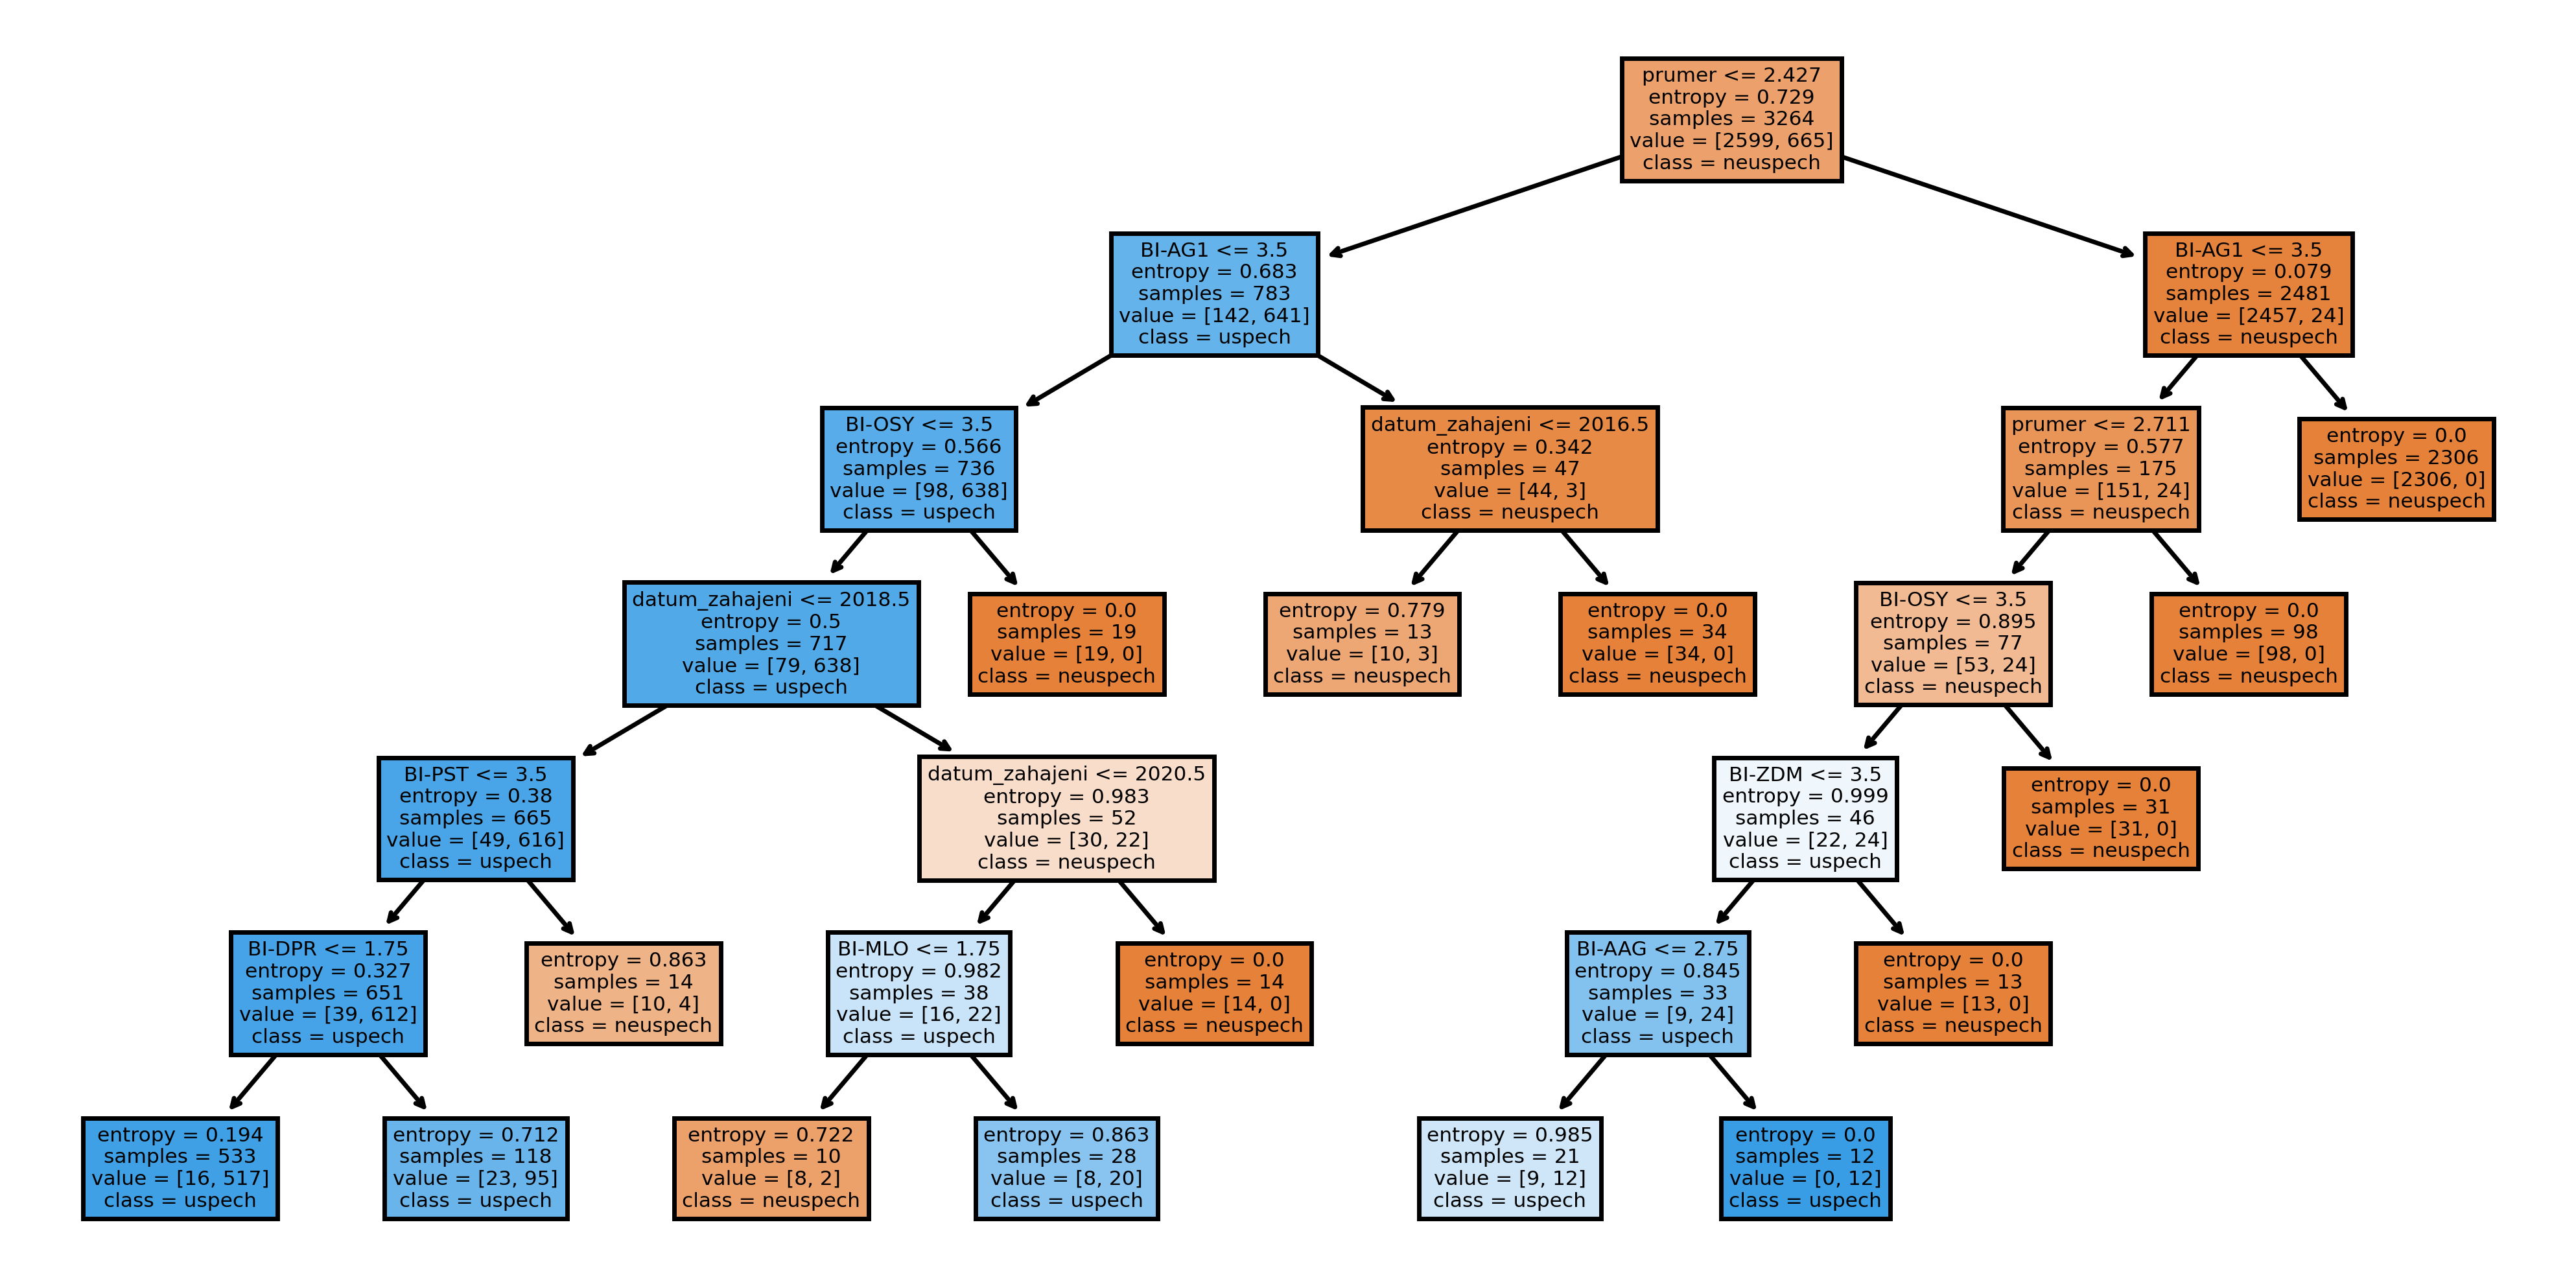

In [29]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_f1.png')

#### Random forest

In [30]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [31]:
rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 25}

0.903235 (+/-0.018350) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.912765 (+/-0.036607) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.924657 (+/-0.015531) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.926135 (+/-0.017073) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.925216 (+/-0.017063) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.927879 (+/-0.017421) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.921690 (+/-0.023002) for {'criterion': 'gini', 'max_depth': 2, 

In [32]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.975184
accuracy score (test): 0.971848


In [33]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
31                  prumer            0.258727
21                  BI-AG1            0.156944
22                  BI-AAG            0.149698
20                  BI-LIN            0.120225
17                  BI-PA2            0.092766
26                  BI-BEZ            0.056938
23                  BI-ZDM            0.040095
24                  BI-OSY            0.030836
25                  BI-PSI            0.025669
11                  BI-PA1            0.023348
2           datum_zahajeni            0.011423
13                  BI-CAO            0.008671
27                  BI-PST            0.008553
28                  BI-DPR            0.006146
16                  BI-ZMA            0.004357
3             rok_maturity            0.001541
8                     olym            0.001534
15                  BI-MLO            0.001346
30                  BI-EMP            0.001182
18                  BI-DBS            0.000000
19                  BI-SAP            0.000000
12                  BI-PAI            0.000000
10               prominuti            0.000000
9                  zkouska            0.000000
1                  je_cech            0.000000
7                     scio            0.000000
6                    praha            0.000000
5                gymnazium            0.000000
4   maturita_nastup_rozdil            0.000000
14                  BI-PS1            0.000000
29                BI-SI1.2            0.000000
0              pohlavi_kod            0.000000

#### SVM

In [34]:
param_grid_svm = {
    'kernel':['linear', 'rbf'],
    'gamma':['auto', 'scale'],
    'C':[100, 10, 1, 0.1]
}
param_comb_svm = ParameterGrid(param_grid_svm)

In [35]:
svc_f1 = get_best_parameters(param_grid_svm, SVC)

Best hyper-parameters are: 
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

0.934232 (+/-0.022469) for {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
0.950705 (+/-0.026669) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.934232 (+/-0.022469) for {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.937305 (+/-0.015378) for {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.956422 (+/-0.023890) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.937305 (+/-0.015378) for {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.938658 (+/-0.017676) for {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.953859 (+/-0.022467) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.938658 (+/-0.017676) for {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.000000 (+/-0.000000) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.939428 (+/-0.010089) for {'C': 0.1, 'gamma': 'aut

In [36]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, svc_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, svc_f1.predict(Xtest))))

accuracy score (train): 0.997243
accuracy score (test): 0.979192


#### Adaboost

In [37]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [38]:
ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.30000000000000004, 'n_estimators': 45}

0.910341 (+/-0.028274) for {'learning_rate': 0.1, 'n_estimators': 5}
0.935265 (+/-0.027648) for {'learning_rate': 0.1, 'n_estimators': 10}
0.936203 (+/-0.019778) for {'learning_rate': 0.1, 'n_estimators': 15}
0.943227 (+/-0.021631) for {'learning_rate': 0.1, 'n_estimators': 20}
0.946252 (+/-0.019484) for {'learning_rate': 0.1, 'n_estimators': 25}
0.953824 (+/-0.018190) for {'learning_rate': 0.1, 'n_estimators': 30}
0.957233 (+/-0.028103) for {'learning_rate': 0.1, 'n_estimators': 35}
0.967649 (+/-0.024109) for {'learning_rate': 0.1, 'n_estimators': 40}
0.967691 (+/-0.022304) for {'learning_rate': 0.1, 'n_estimators': 45}
0.920516 (+/-0.009104) for {'learning_rate': 0.2, 'n_estimators': 5}
0.932502 (+/-0.023440) for {'learning_rate': 0.2, 'n_estimators': 10}
0.940489 (+/-0.025915) for {'learning_rate': 0.2, 'n_estimators': 15}
0.949480 (+/-0.025316) for {'learning_rate': 0.2, 'n_estimators': 20}
0.96

In [39]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.992341
accuracy score (test): 0.991432


In [40]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

features  feature_importance
4   maturita_nastup_rozdil            0.155556
27                  BI-PST            0.133333
2           datum_zahajeni            0.088889
28                  BI-DPR            0.088889
21                  BI-AG1            0.088889
31                  prumer            0.066667
30                  BI-EMP            0.066667
19                  BI-SAP            0.066667
24                  BI-OSY            0.044444
17                  BI-PA2            0.022222
23                  BI-ZDM            0.022222
22                  BI-AAG            0.022222
20                  BI-LIN            0.022222
18                  BI-DBS            0.022222
16                  BI-ZMA            0.022222
3             rok_maturity            0.022222
13                  BI-CAO            0.022222
11                  BI-PA1            0.022222
15                  BI-MLO            0.000000
25                  BI-PSI            0.000000
29                BI-SI1.2            0.000000
5                gymnazium            0.000000
6                    praha            0.000000
26                  BI-BEZ            0.000000
8                     olym            0.000000
7                     scio            0.000000
1                  je_cech            0.000000
9                  zkouska            0.000000
10               prominuti            0.000000
12                  BI-PAI            0.000000
14                  BI-PS1            0.000000
0              pohlavi_kod            0.000000

#### Xgboost

In [41]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [42]:
xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 4}

0.966281 (+/-0.025542) for {'eta': 0.1, 'max_depth': 3}
0.967644 (+/-0.020003) for {'eta': 0.1, 'max_depth': 4}
0.966751 (+/-0.016446) for {'eta': 0.1, 'max_depth': 5}
0.964356 (+/-0.025147) for {'eta': 0.1, 'max_depth': 6}
0.965175 (+/-0.027240) for {'eta': 0.1, 'max_depth': 7}
0.966752 (+/-0.019952) for {'eta': 0.2, 'max_depth': 3}
0.966742 (+/-0.021082) for {'eta': 0.2, 'max_depth': 4}
0.964598 (+/-0.016992) for {'eta': 0.2, 'max_depth': 5}
0.959904 (+/-0.024569) for {'eta': 0.2, 'max_depth': 6}
0.960059 (+/-0.027752) for {'eta': 0.2, 'max_depth': 7}
0.963200 (+/-0.015273) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.963851 (+/-0.023672) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.962251 (+/-0.017987) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.959343 (+/-0.018851) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.959980 (+/-0.026975) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.960953 (+/-0.023218)

In [43]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_f1.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest))))

accuracy score XGBoost (train): 0.995404
accuracy score XGBoost (val): 0.986536


In [44]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [45]:
feat_imp

BI-DPR                    63.0
prumer                    43.0
datum_zahajeni            40.0
BI-AG1                    39.0
BI-OSY                    38.0
BI-AAG                    37.0
BI-LIN                    36.0
BI-PA1                    36.0
BI-PST                    34.0
rok_maturity              32.0
maturita_nastup_rozdil    29.0
BI-ZDM                    28.0
BI-PA2                    28.0
BI-EMP                    24.0
BI-SAP                    22.0
BI-PS1                    18.0
BI-DBS                    16.0
BI-ZMA                    16.0
BI-PSI                    10.0
BI-MLO                     5.0
gymnazium                  5.0
BI-BEZ                     4.0
BI-SI1.2                   4.0
BI-CAO                     1.0
BI-PAI                     1.0
praha                      1.0
je_cech                    1.0
dtype: float64

#### MLP

In [46]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

In [47]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.923100
accuracy score mlp (val): 0.925337


#### Lineární regrese

In [48]:
reg = LinearRegression().fit(Xtrain, ytrain)

In [49]:
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtrain), np.array(ytrain))))
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtest), np.array(ytest))))

RMSE reg (test): 0.19208452761133418
RMSE reg (test): 0.20101163019047813


#### kNN

In [50]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [51]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

0.928104 (+/-0.009839) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.928104 (+/-0.009839) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.927991 (+/-0.026535) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.927991 (+/-0.026535) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.925298 (+/-0.027172) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.928104 (+/-0.009839) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.928941 (+/-0.020715) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.927991 (+/-0.026535) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.925998 (+/-0.034130) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.926645 (+/-0.034007) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.921946 (+/-0.031214) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.921946 (+/-0.031214) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.93

In [52]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.984069
accuracy score knn (val): 0.970624


## Testování po semestrech

### Doplnění 0

#### Pouze nepředmětové příznaky

In [53]:
Xtest_0 = Xtest.copy(deep=True)

courses_not_use = courses
for course in courses_not_use:
    Xtest_0.loc[:, course] = 0
Xtest_0.loc[:, 'prumer'] = 0

#### 1. semestr

In [54]:
Xtest_1 = Xtest.copy(deep=True)

courses_not_use = courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7
for course in courses_not_use:
    Xtest_1.loc[:, course] = 0

courses_to_use = courses_1
Xtest_1.loc[:, 'prumer'] = Xtest_1.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První dva semestry

In [55]:
Xtest_2 = Xtest.copy(deep=True)

courses_not_use = courses_3 + courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_2.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2
Xtest_2.loc[:, 'prumer'] = Xtest_2.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První tři semestry

In [56]:
Xtest_3 = Xtest.copy(deep=True)

courses_not_use = courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_3.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3
Xtest_3.loc[:, 'prumer'] = Xtest_3.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První čtyři semestry 

In [57]:
Xtest_4 = Xtest.copy(deep=True)

courses_not_use = courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_4.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4
Xtest_4.loc[:, 'prumer'] = Xtest_4.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Prvních pět semestrů

In [58]:
Xtest_5 = Xtest.copy(deep=True)

courses_not_use = courses_6 + courses_7

for course in courses_not_use:
    Xtest_5.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5
Xtest_5.loc[:, 'prumer'] = Xtest_5.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Všechny semestry bez SI1.2 a EMP

In [59]:
Xtest_6 = Xtest.copy(deep=True)

courses_not_use = courses_7

for course in courses_not_use:
    Xtest_6.loc[:, course] = 0
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6
Xtest_6.loc[:, 'prumer'] = Xtest_6.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

### Doplnění průměrem

#### Pouze nepředmětové příznaky

In [60]:
Xtest_0_mean = Xtest.copy(deep=True)

courses_not_use = courses
for course in courses_not_use:
    Xtest_0_mean.loc[:, course] = means[course]
    
Xtest_0_mean.loc[:, 'prumer'] = Xtest_0.loc[:, courses[0]:courses[-1]].mean(axis=1)

#### První semestr

In [61]:
Xtest_1_mean = Xtest.copy(deep=True)

courses_not_use = courses_2 + courses_3 + courses_4 + courses_5 + courses_6 + courses_7
for course in courses_not_use:
    Xtest_1_mean.loc[:, course] = means[course]

courses_to_use = courses_1
Xtest_1_mean['prumer'] = Xtest_1_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První dva semestry

In [62]:
Xtest_2_mean = Xtest.copy(deep=True)

courses_not_use = courses_3 + courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_2_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2
Xtest_2_mean['prumer'] = Xtest_2_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První tři semestry

In [63]:
Xtest_3_mean = Xtest.copy(deep=True)

courses_not_use = courses_4 + courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_3_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3
Xtest_3_mean['prumer'] = Xtest_3_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### První čtyři semestry 

In [64]:
Xtest_4_mean = Xtest.copy(deep=True)

courses_not_use = courses_5 + courses_6 + courses_7

for course in courses_not_use:
    Xtest_4_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4
Xtest_4_mean['prumer'] = Xtest_4_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Prvních pět semestrů

In [65]:
Xtest_5_mean = Xtest.copy(deep=True)

courses_not_use = courses_6 + courses_7

for course in courses_not_use:
    Xtest_5_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5
Xtest_5_mean['prumer'] = Xtest_5_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

#### Všechny semestry bez SI1.2 a EMP

In [66]:
Xtest_6_mean = Xtest.copy(deep=True)

courses_not_use = courses_7

for course in courses_not_use:
    Xtest_6_mean.loc[:, course] = means[course]
    
courses_to_use = courses_1 + courses_2 + courses_3 + courses_4 + courses_5 + courses_6
Xtest_6_mean['prumer'] = Xtest_6_mean.loc[:, courses_to_use[0]:courses_to_use[-1]].mean(axis=1)

## Výsledky

In [67]:
results = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_mean = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])

results_f1 = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_mean_f1 = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'mlp', 'knn'], index=[0, 1, 2, 3, 4, 5, 6, 7])

In [68]:
results_reg = pd.DataFrame(columns=['reg'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_reg_mean = pd.DataFrame(columns=['reg'], index=[0, 1, 2, 3, 4, 5, 6, 7])

### Linearní regrese měřena pomocí RMSE

#### Doplněno 0

In [69]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):   
    results_reg.loc[i, 'reg'] = round(np.sqrt(mean_squared_error(reg.predict(x_test[i]), np.array(ytest))), 3)

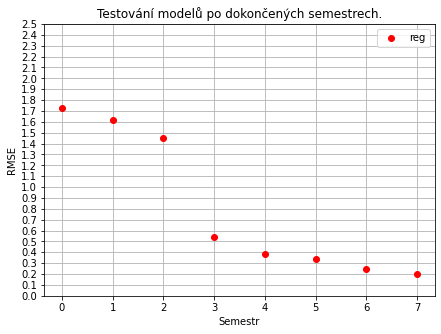

In [70]:
plt.figure(figsize=(7,5))
plt.grid(True)

xreg = results_reg['reg'].index
yreg = results_reg['reg'].values

y_values = np.arange(0.0, 2.55, 0.1)

plt.plot(xreg, yreg, 'o', color='r', label='reg')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('RMSE')

plt.legend()

plt.show()

In [71]:
results_reg

reg
0  1.726
1  1.613
2  1.448
3  0.542
4  0.386
5  0.335
6  0.246
7  0.201

#### Doplněno průměrem

In [72]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_reg_mean.loc[i, 'reg'] = round(np.sqrt(mean_squared_error(reg.predict(x_test_mean[i]), np.array(ytest))), 3)

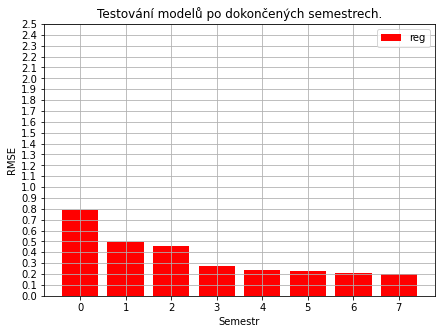

In [73]:
plt.figure(figsize=(7,5))
plt.grid(True)

xreg = results_reg_mean['reg'].index
yreg = results_reg_mean['reg'].values

y_values = np.arange(0.0, 2.55, 0.1)

plt.bar(xreg, yreg, color='r', label='reg')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('RMSE')

plt.legend()

plt.show()

In [74]:
results_reg_mean

reg
0  0.793
1  0.498
2  0.454
3  0.273
4  0.237
5  0.226
6  0.212
7  0.201

## Ostatní modely
### Měřeno accuracy_score

In [75]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):
    results.loc[i, 'dt'] = round(metrics.accuracy_score(ytest, dt_f1.predict(x_test[i])), 3)
    results.loc[i, 'rf'] = round(metrics.accuracy_score(ytest, rf_f1.predict(x_test[i])), 3)
    results.loc[i, 'svm'] = round(metrics.accuracy_score(ytest, svc_f1.predict(x_test[i])), 3)
    results.loc[i, 'ab'] = round(metrics.accuracy_score(ytest, ab_f1.predict(x_test[i])), 3)
    results.loc[i, 'xgb'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(x_test[i])), 3)
    results.loc[i, 'mlp'] = round(metrics.accuracy_score(ytest, mlp.predict(x_test[i])), 3)
    results.loc[i, 'knn'] = round(metrics.accuracy_score(ytest, knn.predict(x_test[i])), 3)

In [76]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_mean.loc[i, 'dt'] = round(metrics.accuracy_score(ytest, dt_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'rf'] = round(metrics.accuracy_score(ytest, rf_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'svm'] = round(metrics.accuracy_score(ytest, svc_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'ab'] = round(metrics.accuracy_score(ytest, ab_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'xgb'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'mlp'] = round(metrics.accuracy_score(ytest, mlp.predict(x_test_mean[i])), 3)
    results_mean.loc[i, 'knn'] = round(metrics.accuracy_score(ytest, knn.predict(x_test_mean[i])), 3)

#### Po doplnění 0

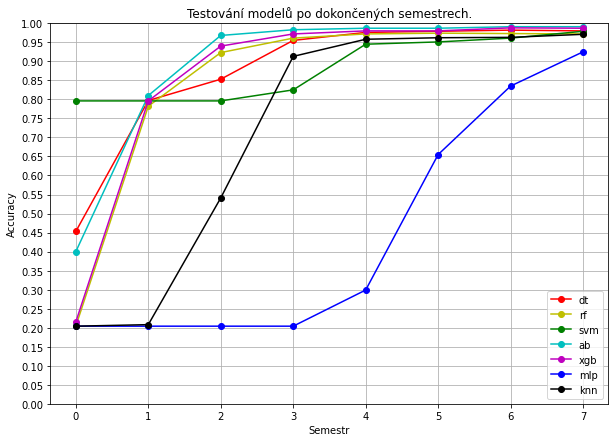

In [77]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results['dt'].index
ydt = results['dt'].values

xrf = results['rf'].index
yrf = results['rf'].values

xsvm = results['svm'].index
ysvm = results['svm'].values

xab = results['ab'].index
yab = results['ab'].values

xxgb = results['xgb'].index
yxgb = results['xgb'].values

xmlp = results['mlp'].index
ymlp = results['mlp'].values

xknn = results['knn'].index
yknn = results['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('Accuracy')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

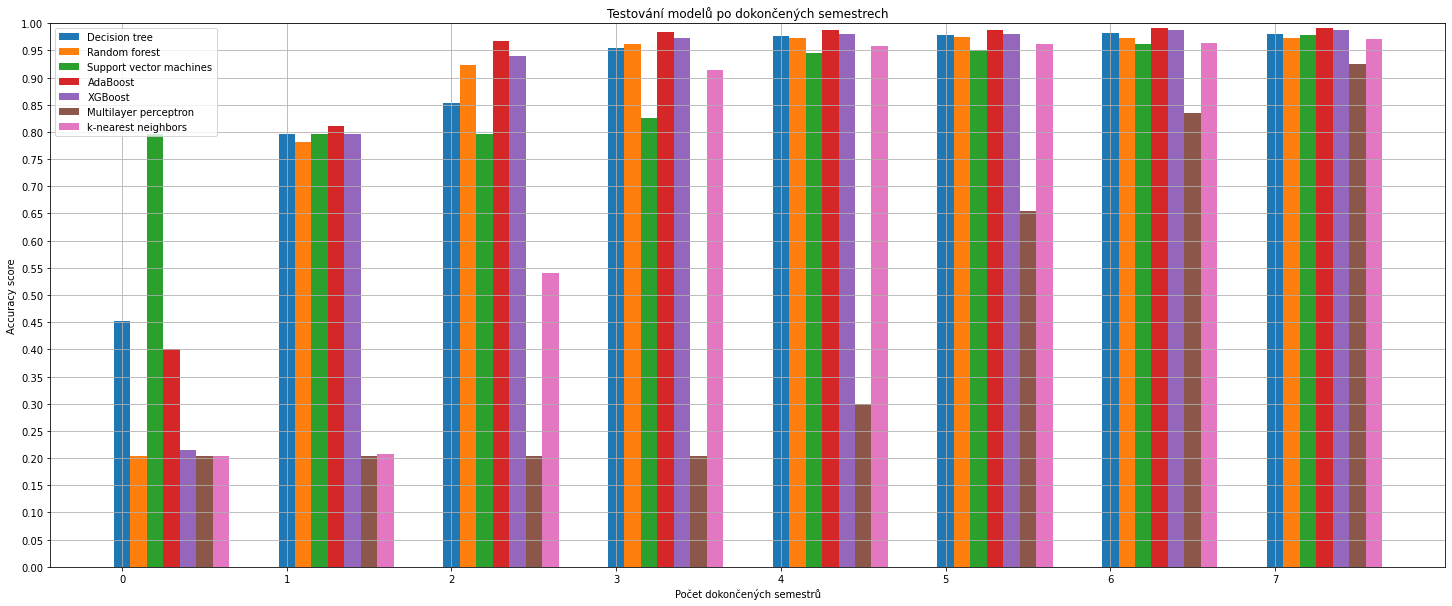

In [78]:
labels = np.array(results.index)

ydt = results['dt'].values

yrf = results['rf'].values

ysvm = results['svm'].values

yab = results['ab'].values

yxgb = results['xgb'].values

ymlp = results['mlp'].values

yknn = results['knn'].values

x = np.arange(len(labels))*2  # the label locations
width = 0.2  # the width of the bars


fig, ax = plt.subplots()
rects_dt = ax.bar(x , ydt, width, label='Decision tree')
rects_rf = ax.bar(x + width, yrf, width, label='Random forest')
rects_svm = ax.bar(x + width * 2, ysvm, width, label='Support vector machines')
rects_ab = ax.bar(x + width * 3, yab, width, label='AdaBoost')
rects_xgb = ax.bar(x + width * 4, yxgb, width, label='XGBoost')
rects_mlp = ax.bar(x + width * 5, ymlp, width, label='Multilayer perceptron')
rects_knn = ax.bar(x + width * 6, yknn, width, label='k-nearest neighbors')

y_values = np.arange(0.0, 1.05, 0.05)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Počet dokončených semestrů')
ax.set_title('Testování modelů po dokončených semestrech')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.yticks(y_values)
ax.legend(loc='best')
ax.grid(True)

plt.ylim(ymin=0)
plt.ylim(ymax=1)

fig.set_size_inches(25,10)
plt.show()

In [79]:
results

dt     rf    svm     ab    xgb    mlp    knn
0  0.453  0.204  0.796    0.4  0.215  0.204  0.204
1  0.797  0.782  0.796   0.81  0.796  0.204  0.208
2  0.853  0.923  0.796  0.968   0.94  0.204  0.541
3  0.955  0.961  0.825  0.983  0.972  0.204  0.913
4  0.976  0.972  0.945  0.987   0.98  0.299  0.958
5  0.979  0.974  0.951  0.987   0.98  0.655  0.962
6  0.982  0.973  0.961  0.991  0.988  0.835  0.963
7   0.98  0.972  0.979  0.991  0.987  0.925  0.971

#### Po doplněni průměrem

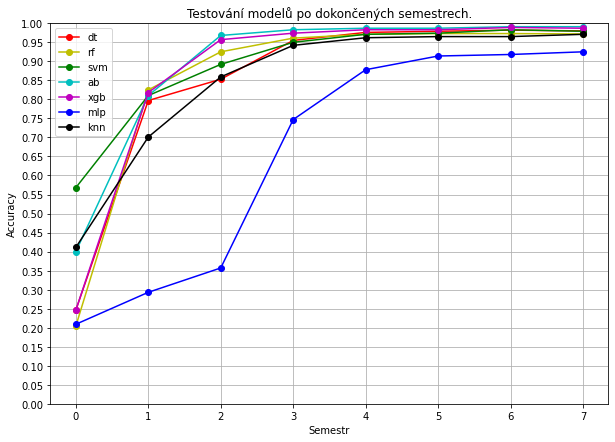

In [80]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_mean['dt'].index
ydt = results_mean['dt'].values

xrf = results_mean['rf'].index
yrf = results_mean['rf'].values

xsvm = results_mean['svm'].index
ysvm = results_mean['svm'].values

xab = results_mean['ab'].index
yab = results_mean['ab'].values

xxgb = results_mean['xgb'].index
yxgb = results_mean['xgb'].values

xmlp = results_mean['mlp'].index
ymlp = results_mean['mlp'].values

xknn = results_mean['knn'].index
yknn = results_mean['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('Accuracy')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [81]:
results_mean

dt     rf    svm     ab    xgb    mlp    knn
0  0.246  0.204  0.568    0.4  0.246  0.209  0.411
1  0.797  0.825   0.81   0.81  0.818  0.293  0.701
2  0.853  0.925  0.892  0.968  0.957  0.357  0.859
3  0.955  0.961   0.95  0.983  0.974  0.747  0.942
4  0.976  0.971  0.971  0.987  0.983  0.878  0.962
5  0.979  0.973  0.974  0.987  0.983  0.914  0.965
6  0.982  0.973  0.983  0.991  0.989  0.918  0.965
7   0.98  0.972  0.979  0.991  0.987  0.925  0.971

### Měřeno f1_score

In [82]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):
    results_f1.loc[i, 'dt'] = round(metrics.f1_score(ytest, dt_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'rf'] = round(metrics.f1_score(ytest, rf_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'svm'] = round(metrics.f1_score(ytest, svc_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'ab'] = round(metrics.f1_score(ytest, ab_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'xgb'] = round(metrics.f1_score(ytest, xgb_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'mlp'] = round(metrics.f1_score(ytest, mlp.predict(x_test[i])), 3)
    results_f1.loc[i, 'knn'] = round(metrics.f1_score(ytest, knn.predict(x_test[i])), 3)

In [83]:
x_test_mean = {0:Xtest_0_mean, 1:Xtest_1_mean, 2:Xtest_2_mean, 3:Xtest_3_mean, 4:Xtest_4_mean, 5:Xtest_5_mean, 6:Xtest_6_mean, 7:Xtest}
for i in range(0, 8):
    results_mean_f1.loc[i, 'dt'] = round(metrics.f1_score(ytest, dt_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'rf'] = round(metrics.f1_score(ytest, rf_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'svm'] = round(metrics.f1_score(ytest, svc_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'ab'] = round(metrics.f1_score(ytest, ab_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'xgb'] = round(metrics.f1_score(ytest, xgb_f1.predict(x_test_mean[i])), 3)
    results_mean_f1.loc[i, 'mlp'] = round(metrics.f1_score(ytest, mlp.predict(x_test[i])), 3)
    results_mean_f1.loc[i, 'knn'] = round(metrics.f1_score(ytest, knn.predict(x_test[i])), 3)

#### Po doplnění 0

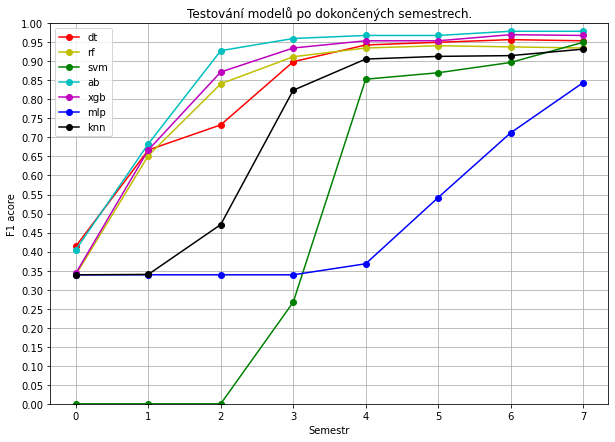

In [84]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_f1['dt'].index
ydt = results_f1['dt'].values

xrf = results_f1['rf'].index
yrf = results_f1['rf'].values

xsvm = results_f1['svm'].index
ysvm = results_f1['svm'].values

xab = results_f1['ab'].index
yab = results_f1['ab'].values

xxgb = results_f1['xgb'].index
yxgb = results_f1['xgb'].values

xmlp = results_f1['mlp'].index
ymlp = results_f1['mlp'].values

xknn = results_f1['knn'].index
yknn = results_f1['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('F1 acore')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [85]:
results_f1

dt     rf    svm     ab    xgb    mlp    knn
0  0.414  0.339      0  0.405  0.343  0.339  0.339
1  0.667  0.652      0  0.683  0.667  0.339   0.34
2  0.733  0.841      0  0.928  0.872  0.339  0.471
3  0.899  0.912  0.267   0.96  0.935  0.339  0.824
4  0.943  0.935  0.853  0.968  0.954  0.368  0.906
5   0.95  0.941   0.87  0.968  0.954  0.542  0.913
6  0.957  0.938  0.897  0.979   0.97  0.712  0.915
7  0.954  0.935   0.95  0.979  0.968  0.844  0.932

#### Po doplněni průměrem

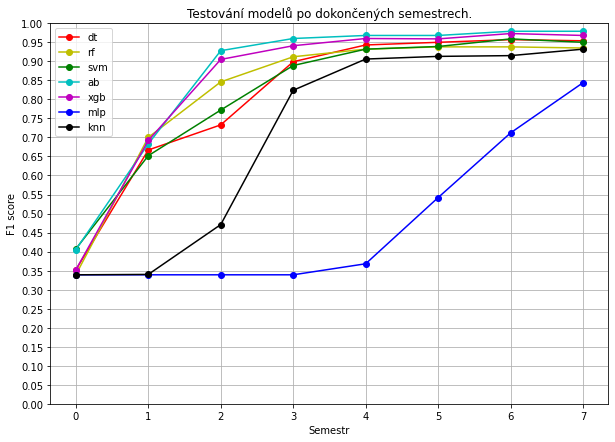

In [86]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_mean_f1['dt'].index
ydt = results_mean_f1['dt'].values

xrf = results_mean_f1['rf'].index
yrf = results_mean_f1['rf'].values

xsvm = results_mean_f1['svm'].index
ysvm = results_mean_f1['svm'].values

xab = results_mean_f1['ab'].index
yab = results_mean_f1['ab'].values

xxgb = results_mean_f1['xgb'].index
yxgb = results_mean_f1['xgb'].values

xmlp = results_mean_f1['mlp'].index
ymlp = results_mean_f1['mlp'].values

xknn = results_mean_f1['knn'].index
yknn = results_mean_f1['knn'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, '-o', color='r', label='dt')
plt.plot(xrf, yrf, '-o', color='y', label='rf')
plt.plot(xsvm, ysvm, '-o', color='g', label='svm')
plt.plot(xab, yab, '-o', color='c', label='ab')
plt.plot(xxgb, yxgb, '-o', color='m', label='xgb')
plt.plot(xmlp, ymlp, '-o', color='b', label='mlp')
plt.plot(xknn, yknn, '-o', color='k', label='knn')


plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('F1 score')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [88]:
results_mean_f1

dt     rf    svm     ab    xgb    mlp    knn
0  0.352  0.339  0.407  0.405  0.352  0.339  0.339
1  0.667    0.7  0.652  0.683  0.692  0.339   0.34
2  0.733  0.846  0.772  0.928  0.905  0.339  0.471
3  0.899  0.912  0.889   0.96  0.941  0.339  0.824
4  0.943  0.932  0.932  0.968   0.96  0.368  0.906
5   0.95  0.938  0.939  0.968  0.959  0.542  0.913
6  0.957  0.938  0.959  0.979  0.973  0.712  0.915
7  0.954  0.935   0.95  0.979  0.968  0.844  0.932